# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Обзор данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import catboost as cb
import xgboost as xgb
import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    data = pd.read_csv("/datasets/autos.csv")
except:
    data = pd.read_csv("datasets/autos.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [5]:
data.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

В признаках обнаружены пропуски. Больше всего пропусков наблюдается в `NotRepaired`

Кроме того, у некоторых признаков не тот формат данных (`DateCrawled`,`DateCreated`,`LastSeen`).

In [6]:
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
data["DateCreated"].sort_values(ascending = True).unique()

array(['2014-03-10 00:00:00', '2015-03-20 00:00:00',
       '2015-06-18 00:00:00', '2015-08-07 00:00:00',
       '2015-08-10 00:00:00', '2015-09-04 00:00:00',
       '2015-09-09 00:00:00', '2015-11-02 00:00:00',
       '2015-11-08 00:00:00', '2015-11-10 00:00:00',
       '2015-11-12 00:00:00', '2015-11-17 00:00:00',
       '2015-11-23 00:00:00', '2015-11-24 00:00:00',
       '2015-12-05 00:00:00', '2015-12-06 00:00:00',
       '2015-12-17 00:00:00', '2015-12-27 00:00:00',
       '2015-12-30 00:00:00', '2016-01-02 00:00:00',
       '2016-01-03 00:00:00', '2016-01-06 00:00:00',
       '2016-01-07 00:00:00', '2016-01-08 00:00:00',
       '2016-01-10 00:00:00', '2016-01-13 00:00:00',
       '2016-01-15 00:00:00', '2016-01-16 00:00:00',
       '2016-01-17 00:00:00', '2016-01-18 00:00:00',
       '2016-01-19 00:00:00', '2016-01-20 00:00:00',
       '2016-01-22 00:00:00', '2016-01-23 00:00:00',
       '2016-01-24 00:00:00', '2016-01-25 00:00:00',
       '2016-01-26 00:00:00', '2016-01-27 00:0

Диапазон дат варьируется от 2014 до 2016 года

In [8]:
columns_numeric = ['Price', 'RegistrationYear', 'Power', 'Kilometer']

def numeric(data, columns_numeric):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    for column, ax in zip(columns_numeric,axes.ravel()):
        ax.set_title(column)
        sns.distplot(data[column], ax=ax)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    for column, ax in zip(columns_numeric, axes.ravel()):
        ax.set_title(column)
        sns.boxplot(data[column], ax=ax)

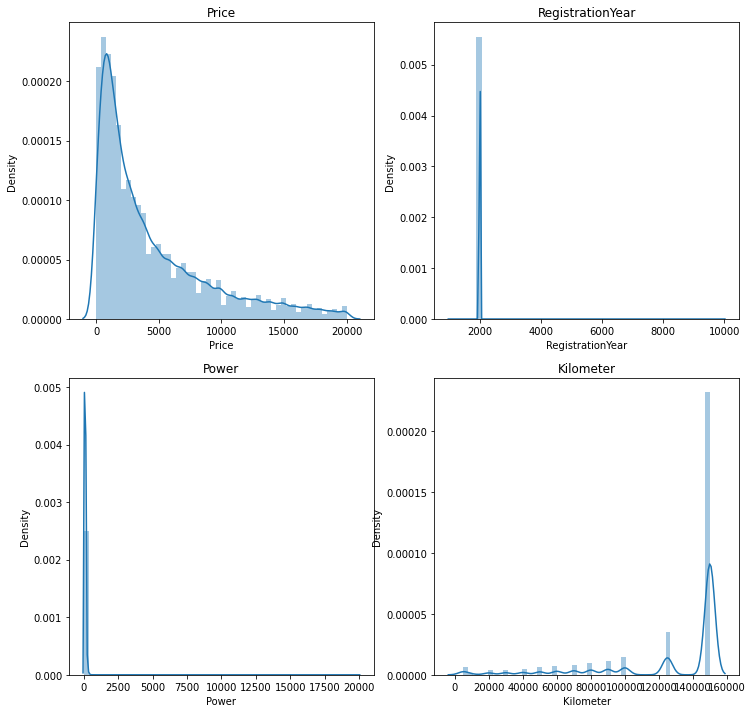

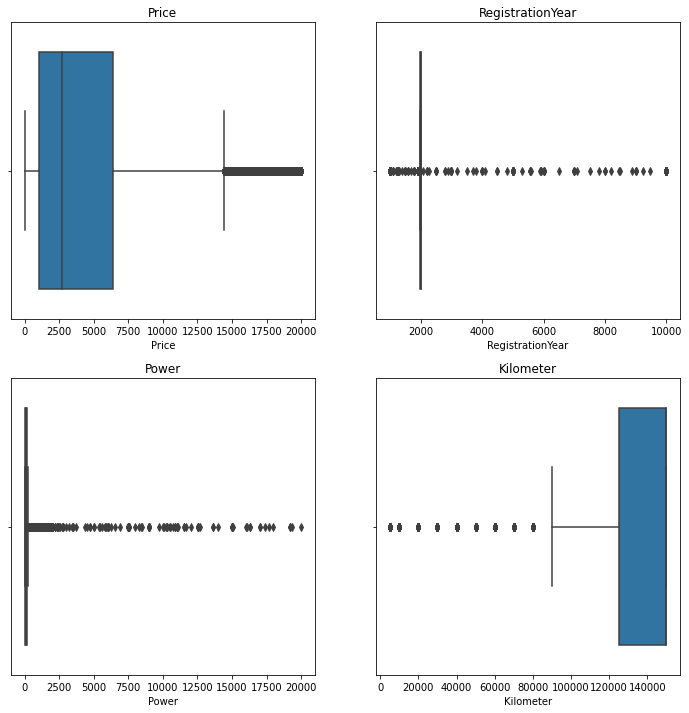

In [9]:
numeric(data, columns_numeric)

In [10]:
columns_to_drop = ['DateCrawled', 'LastSeen', 'DateCreated', 'NumberOfPictures', 'PostalCode',"RegistrationMonth"]
data = data.drop(columns=columns_to_drop)

In [11]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


#### Вывод:
1. Обнаружены пропуски `VehicleType` , `Gearbox` , `Model` , `FuelType` , `NotRepaired` ;
2. Обнаружены аномалии. Такие как в стоблце `price` минимальная стоимость равняется 0; В `RegistrationYear` минимальный год - 1000, а максимальный 9999; В столбце `Power` минимальная мощность равняется 0, что тоже не может быть (Если это только не полностью сломанная машина); В `RegistrationMonth` минимальный месяц - 0. Скорей всего при заполнении анкеты - данная строка была пропущена.
3. Удалены признаки, не несущие важности при обучении моделей.

### Обработка пропусков

####  Обработка `VehicleType`

In [12]:
data.groupby(['Brand',"Model",'VehicleType'])['VehicleType'].count().head(55)

Brand       Model   VehicleType
alfa_romeo  145     coupe             2
                    other             1
                    sedan            13
                    small            19
            147     coupe            27
                    other             7
                    sedan           358
                    small            97
                    suv               1
                    wagon             2
            156     coupe             3
                    other             1
                    sedan           287
                    small             2
                    wagon           288
            159     sedan            55
                    wagon           145
            other   convertible       1
                    coupe           180
                    other             5
                    sedan           190
                    small           114
                    wagon             6
            spider  convertible     179
        

В каждой модели присутствует категория - `other`. Логичнее всего заполнить пропуски данной категории, так как у одной модели может сразу быть несколько типов.

In [13]:
data["VehicleType"] = data["VehicleType"].fillna("other")

#### Обработка`Gearbox`

In [14]:
data.groupby(['Brand','Gearbox'])['Gearbox'].count().head(55)

Brand          Gearbox
alfa_romeo     auto         143
               manual      2039
audi           auto        8531
               manual     19616
bmw            auto       11020
               manual     24431
chevrolet      auto         579
               manual      1079
chrysler       auto         744
               manual       633
citroen        auto         594
               manual      4284
dacia          auto           1
               manual       877
daewoo         auto          33
               manual       475
daihatsu       auto          85
               manual       667
fiat           auto         218
               manual      8769
ford           auto        1788
               manual     21982
honda          auto         317
               manual      2376
hyundai        auto         382
               manual      3072
jaguar         auto         383
               manual       104
jeep           auto         431
               manual       213
kia            au

Коробка передач в машине можеть быть на механике или автомате, в зависимости от комплектации. В основном доминирует значение `manual` - то заполним пропуски значением `manual`

In [15]:
data["Gearbox"] = data["Gearbox"].fillna("manual")

#### Обоаботка `FuelType`

In [16]:
data['FuelType'].value_counts(dropna=False)

petrol      216352
gasoline     98720
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [17]:
data.groupby(['Brand','FuelType'])['FuelType'].count().head(55)

Brand       FuelType
alfa_romeo  gasoline      611
            lpg            37
            petrol       1444
audi        cng             2
            electric        2
            gasoline    12423
            hybrid          2
            lpg           469
            other           5
            petrol      14305
bmw         cng            10
            electric        3
            gasoline    12118
            lpg           783
            other           8
            petrol      21056
chevrolet   cng             4
            gasoline      243
            hybrid          1
            lpg           180
            other           1
            petrol       1172
chrysler    gasoline      393
            lpg            95
            petrol        828
citroen     cng             8
            electric        2
            gasoline     1618
            lpg            72
            other           3
            petrol       3025
dacia       cng             2
            gasolin

In [18]:
data[data["FuelType"].isna()].head(20)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN
13,2500,wagon,2004,manual,131,passat,150000,NaN,volkswagen,no
26,5555,other,2017,manual,125,c4,125000,NaN,citroen,no
36,1600,other,1991,manual,75,kadett,70000,NaN,opel,NaN
41,7500,sedan,2002,auto,306,e_klasse,150000,NaN,mercedes_benz,NaN
52,1400,other,2016,manual,55,other,5000,NaN,hyundai,NaN
54,4700,wagon,2005,manual,0,signum,150000,NaN,opel,no
57,2399,other,2018,manual,64,other,125000,NaN,seat,no
59,1,suv,1994,manual,286,NaN,150000,NaN,sonstige_autos,NaN
65,10900,other,2017,manual,101,astra,50000,NaN,opel,no


In [19]:
data_audi = data.query('Brand == "audi" and FuelType == "electric"')

In [20]:
data_audi

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
30569,8300,wagon,2008,auto,140,a4,150000,electric,audi,no
71224,800,sedan,1997,manual,102,a4,150000,electric,audi,no


В огромном количестве преобладают машины на бензине. Поэтому пропуски можно заполнить  `petrol`. Еще возникают вопросы по поводу корректности данных, так как например у ауди есть 2 электрические машины 2008 и 1997 года модели а4. На тот момент таких авто еще не существовало.

In [21]:
data['FuelType'] = data['FuelType'].fillna("petrol")

#### Обоаботка `NotRepaired`

In [22]:
data["NotRepaired"].value_counts(dropna=False)

no     247161
NaN     71154
yes     36054
Name: NotRepaired, dtype: int64

Данные пропуски могли возникнуть в результате того, что машина не чинилась - и когда клиент заполнял форму, то пропускал данное поле. Поэтому пропуски можно заполнить `no`

In [23]:
data['NotRepaired'] = data['NotRepaired'].fillna("unknown")

#### Обоаботка `Model`

In [24]:
data["Model"].value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 250, dtype: int64

In [25]:
data.groupby(['Brand','Model'])['Model'].count().head(55)

Brand       Model    
alfa_romeo  145             49
            147            572
            156            629
            159            212
            other          521
            spider         194
audi        100            417
            200             18
            80            1604
            90             103
            a1             595
            a2             373
            a3            6122
            a4            9900
            a5             545
            a6            5541
            a8             529
            other         1033
            q3              15
            q5              97
            q7             205
            tt            1076
bmw         1er           3514
            3er          19761
            5er           7868
            6er            156
            7er           1017
            i3               8
            m_reihe        132
            other          217
            x_reihe       1589
            z_rei

In [26]:
data[data["Model"].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
59,1,suv,1994,manual,286,NaN,150000,petrol,sonstige_autos,unknown
81,350,small,1997,manual,54,NaN,150000,petrol,fiat,yes
115,0,small,1999,manual,0,NaN,5000,petrol,volkswagen,unknown
135,1450,sedan,1992,manual,136,NaN,150000,petrol,audi,no
...,...,...,...,...,...,...,...,...,...,...
354245,560,small,2001,auto,170,NaN,90000,petrol,fiat,yes
354321,9400,wagon,2007,manual,200,NaN,150000,gasoline,sonstige_autos,yes
354338,180,other,1995,manual,0,NaN,125000,petrol,opel,unknown
354351,1900,other,2000,manual,110,NaN,150000,petrol,volkswagen,no


Заполнить модель по тиму кузова и бренду будет некорректно, так как у одной модели может быть разный тип кузова. Наиболее лучшим решением
будет заполнить пропуски как `other`. Так как данная категория присутствует у всех брендов.

In [27]:
data['Model'] = data['Model'].fillna("other")

In [28]:
data.isna().mean()

Price               0.0
VehicleType         0.0
RegistrationYear    0.0
Gearbox             0.0
Power               0.0
Model               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
NotRepaired         0.0
dtype: float64

#### Вывод:
Пропуски в признаках заполнены

### Обработка аномалий

#### Обработка дубликатов

In [29]:
data.duplicated().sum()

48636

Есть предположение, что в основном это похожие анкеты на продаже, поэтому они отображаются как дубликаты. От данных строк избавимся, чтобы не переобучивать модель

In [30]:
data = data.drop_duplicates().reset_index(drop=True)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305733 entries, 0 to 305732
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             305733 non-null  int64 
 1   VehicleType       305733 non-null  object
 2   RegistrationYear  305733 non-null  int64 
 3   Gearbox           305733 non-null  object
 4   Power             305733 non-null  int64 
 5   Model             305733 non-null  object
 6   Kilometer         305733 non-null  int64 
 7   FuelType          305733 non-null  object
 8   Brand             305733 non-null  object
 9   NotRepaired       305733 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.3+ MB


In [32]:
data.duplicated().sum()

0

#### Обработка цены

In [33]:
data["Price"].describe()

count    305733.000000
mean       4520.110328
std        4573.250346
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

In [34]:
data[data["Price"]==0]["Price"].count()

8456

8973 объявлений, где цена за авто равняется 0 евро. Данные строки являются аномалиями - удалим их. Кроме того, много объявлений, где цена вальрируется от 1 до 500. Возьмем минимальный диапазон от 500 евро. 

In [35]:
data = data[data["Price"] > 500]

<AxesSubplot:xlabel='Price', ylabel='Density'>

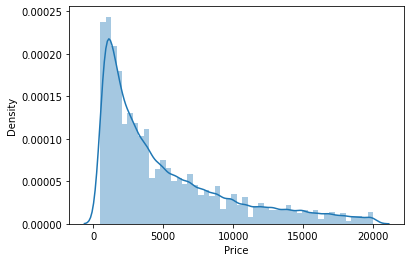

In [36]:
sns.distplot(data["Price"])

<AxesSubplot:xlabel='Price'>

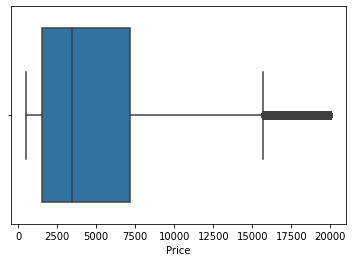

In [37]:
sns.boxplot(data["Price"])

По boxplot есть еще аномалии в цене после 15000 евро. Взглянем поближе на них

In [38]:
data[data["Price"] > 15000]['Brand'].value_counts().head()

volkswagen       2805
bmw              2484
audi             2248
mercedes_benz    2184
ford              574
Name: Brand, dtype: int64

В основном это дорогие марки, поэтому данные не трогаем

#### Обработка `Power`

In [39]:
data[data["Power"]<=0]["Power"].count()

24492

In [40]:
data["Power"].describe()

count    270358.000000
mean        116.843056
std         200.795656
min           0.000000
25%          75.000000
50%         109.000000
75%         150.000000
max       20000.000000
Name: Power, dtype: float64

В мощности минимальное значение 0, а максимальное 20000. Необходимо задать диапозон

<AxesSubplot:xlabel='Power'>

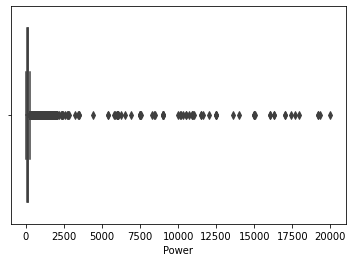

In [41]:
sns.boxplot(data["Power"])

В качестве минимального значения возьмем 50 л.с. , а максимальное 500 л.с. Так как уже почти с 500 л.с. принадлежат супер карам.

In [42]:
data[data['Power'] == 0]["Power"].count()

24492

In [43]:
data[data['Power']<50]["Power"].count()

27942

In [44]:
data[data['Power']<50]["Power"].count() / len(data["Power"]) * 100

10.335185198884442

In [45]:
data[data['Power']>500]["Power"].count()

359

In [46]:
data[data['Power']>500]["Power"].count() / len(data["Power"]) * 100

0.1327868973731127

In [47]:
data.groupby(['Brand','Model',"Power"])['Power'].count().head(55)

Brand       Model  Power
alfa_romeo  145    0          2
                   90         1
                   103       11
                   120        6
                   129        1
                   140        1
                   150        1
                   227        1
            147    0         31
                   77         5
                   86         1
                   101        4
                   102        2
                   104        1
                   105      142
                   110        4
                   115        9
                   116       35
                   118        1
                   120      145
                   122        1
                   140       16
                   144        1
                   150       78
                   170        1
                   175        2
                   200        1
                   208        1
                   250        2
                   15020      1
            156

Таким образом, около 10% данных находятся в диапазоне до 50 л.с. При этом 89% строк с мощностью равняются 0.

На мой взгляд, лучше удалить данные строки. Так как у одной модели бывают разные мощности и восстанавливать по средней в бренд-модель является не совсем корректным. 


In [48]:
data = data.query('50 < Power < 500')

<AxesSubplot:xlabel='Power'>

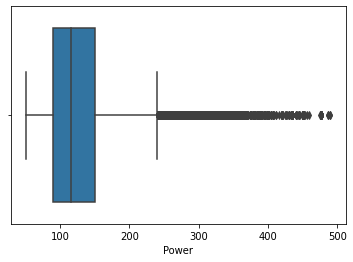

In [49]:
sns.boxplot(data["Power"])

In [50]:
data["Power"].describe()

count    239407.000000
mean        126.092942
std          52.729009
min          51.000000
25%          90.000000
50%         116.000000
75%         150.000000
max         490.000000
Name: Power, dtype: float64

#### Обработка `RegistrationYear`

In [51]:
data["RegistrationYear"].describe()

count    239407.000000
mean       2004.081706
std          27.780983
min        1000.000000
25%        2000.000000
50%        2004.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Также как и с мощностью, зададим новый диапазон. Так как щас минимальный год - 1000. а максимальный 9999.

In [52]:
data["RegistrationYear"].sort_values(ascending = True).unique()

array([1000, 1500, 1800, 1910, 1937, 1941, 1942, 1943, 1947, 1948, 1949,
       1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2800, 2900, 4500, 5000, 5911, 6000, 9999])

После 2019 года идут аномальные значения. Но также стоит отметить, что данные выгружены на 2016 год. 
То тогда можно учитывать, что все даты после 2016 годя являются аномалиями. Посмотрим на количество объявлений между 2016 и 2019 годом

In [53]:
data[(data["RegistrationYear"] > 2017) & (data["RegistrationYear"] < 2020)]["RegistrationYear"].count()

2511

In [54]:
data[(data["RegistrationYear"] > 2017) & (data["RegistrationYear"] < 2020)]["RegistrationYear"].count() / len(data["RegistrationYear"]) * 100

1.0488415125706432

Всего 1.1% между 2016 и 2019 годом. Возьмем верхний предел до 2017 года

In [55]:
data = data[data["RegistrationYear"] < 2017]

In [56]:
data["RegistrationYear"].value_counts(ascending = True).head(55)

1800       1
1941       1
1500       1
1947       1
1948       1
1949       1
1000       1
1937       2
1942       2
1952       2
1910       3
1943       3
1953       4
1954       4
1955       4
1950       4
1957       4
1958       5
1951       6
1959       6
1956       7
1961      12
1962      13
1960      23
1963      25
1964      26
1965      33
1967      42
1968      52
1966      62
1969      63
1971      64
1975      73
1970      74
1973      85
1976      85
1974      90
1977     103
1972     119
1978     169
1981     172
1979     182
1980     196
1982     208
1984     252
1983     264
1986     297
1985     343
1987     423
1988     621
1989     819
2015     923
1990    1391
1991    1668
1992    1801
Name: RegistrationYear, dtype: int64

В качестве манимального года возьмем 1960 год. Так как количество автомобилей старше не так много и , скорей всего, уже не ликвидны.

In [57]:
data = data[data["RegistrationYear"] > 1959]

In [58]:
data["RegistrationYear"].describe()

count    230750.000000
mean       2003.429512
std           6.263131
min        1960.000000
25%        2000.000000
50%        2004.000000
75%        2008.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230750 entries, 1 to 305732
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             230750 non-null  int64 
 1   VehicleType       230750 non-null  object
 2   RegistrationYear  230750 non-null  int64 
 3   Gearbox           230750 non-null  object
 4   Power             230750 non-null  int64 
 5   Model             230750 non-null  object
 6   Kilometer         230750 non-null  int64 
 7   FuelType          230750 non-null  object
 8   Brand             230750 non-null  object
 9   NotRepaired       230750 non-null  object
dtypes: int64(4), object(6)
memory usage: 19.4+ MB


#### Вывод:
Аномалии были отработаны

<AxesSubplot:>

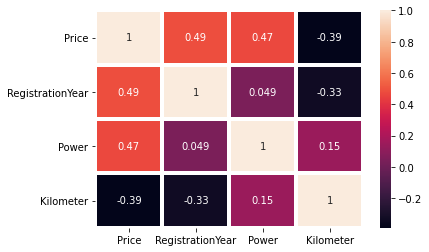

In [60]:
sns.heatmap(data.corr(), annot=True, linewidths=3, linecolor='white')

По таблиице видно, что наблюадется средняя корреляция между мощностью от цены и датой регистрации авто от цены. Также наблюдается обратная корреляция цены от пробега автомобился.

Обратная корреляция также наблюдается между пробегом и годом регистрации авто. 

Что в целом логично, чем больше мощность авто - тем больше цена. 
И также с пробегом: чем больше пробег - тем цена должна уменьшаться

### Подготовка данных для обучения

Проверим модели на 2 разных датасетов с различными способами кодировки:

1. Ordinal Encoding
2. One-Hot Enconding

In [61]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [62]:
columns_cod = ["VehicleType", "Gearbox", "Model", "FuelType", "Brand", "NotRepaired"]

In [63]:
#One-Hot Enconding
data_ohe = pd.get_dummies(data, drop_first = True)

In [64]:
data_ohe.head()

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
1,18300,2011,190,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [65]:
#Ordinal Encoding
encoder = OrdinalEncoder()
data_oe = data.copy()
data_oe[columns_cod] = encoder.fit_transform(data[columns_cod])

In [66]:
data_oe.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,2.0,2011,1.0,190,165.0,125000,2.0,1.0,2.0
2,9800,6.0,2004,0.0,163,116.0,125000,2.0,14.0,1.0
3,1500,5.0,2001,1.0,75,115.0,150000,6.0,38.0,0.0
4,3600,5.0,2008,1.0,69,100.0,90000,2.0,31.0,0.0
5,650,4.0,1995,1.0,102,11.0,150000,6.0,2.0,2.0


Разобьем исходный датасет на выборки

#### One-Hot Enconding

In [67]:
data_train_ohe, data_valid_ohe = train_test_split(data_ohe, test_size=0.2, random_state=12345)
data_valid_ohe, data_test_ohe = train_test_split(data_valid_ohe , test_size=0.2, random_state=12345)

In [68]:
features_train_ohe = data_train_ohe.drop(columns=['Price'])
target_train_ohe = data_train_ohe['Price']

features_valid_ohe = data_valid_ohe.drop(columns=['Price'])
target_valid_ohe = data_valid_ohe['Price']

features_test_ohe = data_test_ohe.drop(columns=['Price'])
target_test_ohe = data_test_ohe['Price']

#### Ordinal Encoding

In [69]:
data_train_oe, data_valid_oe = train_test_split(data_oe, test_size=0.2, random_state=12345)
data_valid_oe, data_test_oe = train_test_split(data_valid_oe , test_size=0.2, random_state=12345)

In [70]:
features_train_oe = data_train_oe.drop(columns=['Price'])
target_train_oe = data_train_oe['Price']

features_valid_oe = data_valid_oe.drop(columns=['Price'])
target_valid_oe = data_valid_oe['Price']

features_test_oe = data_test_oe.drop(columns=['Price'])
target_test_oe = data_test_oe['Price']

## Обучение моделей

### Линейная регрессия

In [71]:
%%time

model = LinearRegression()
start_time = time.time()
model.fit(features_train_ohe, target_train_ohe)
time_lr_ohe_fit = time.time() - start_time


predict_lr = pd.DataFrame(model.predict(features_valid_ohe))
score_lr_ohe = mean_squared_error(target_valid_ohe, predict_lr) ** 0.5
time_lr_ohe = time.time() -  start_time 

print("RMSE LinearRegression:", score_lr_ohe)
print("Время обучения:",time_lr_ohe_fit)
print("Время выполнения:",time_lr_ohe)

RMSE LinearRegression: 2612.749226020545
Время обучения: 19.1530601978302
Время выполнения: 19.44792628288269
CPU times: user 10.7 s, sys: 8.79 s, total: 19.5 s
Wall time: 19.5 s


In [72]:
%%time

model = LinearRegression()
start_time = time.time()
model.fit(features_train_oe, target_train_oe)
time_lr_oe_fit = time.time() - start_time

predict_lr = pd.DataFrame(model.predict(features_valid_oe))
score_lr_oe = mean_squared_error(target_valid_oe, predict_lr) ** 0.5
time_lr_oe = time.time() -  start_time

print("RMSE LinearRegression:", score_lr_oe)
print("Время обучения:",time_lr_oe_fit)
print("Время выполнения:",time_lr_oe)

RMSE LinearRegression: 2978.004099920741
Время обучения: 0.047013044357299805
Время выполнения: 0.19569778442382812
CPU times: user 87.4 ms, sys: 108 ms, total: 195 ms
Wall time: 196 ms


### LightGBM

Параметры были подобраны с помощью GreadSearch ниже. Для ускорения процесса работы - лучшие параметры использовалиь в модели, а ячейки с GreadSearch закомментированы.

In [73]:
%%time

lgbm_model = LGBMRegressor(num_leaves=41, learning_rate=0.06, n_estimators=500, random_state=12345)
start_time = time.time()
lgbm_model.fit(features_train_ohe, target_train_ohe)
time_lgbm_ohe_fit = time.time() - start_time
predict_lgbm = pd.DataFrame(lgbm_model.predict(features_valid_ohe))

score_lgbm_ohe = mean_squared_error(target_valid_ohe, predict_lgbm) ** 0.5
time_lgmb_ohe = time.time() -  start_time

print("RMSE LGBMRegressor:", score_lgbm_ohe)
print("Время обучения:",time_lgbm_ohe_fit)
print("Время выполнения:",time_lgmb_ohe)

RMSE LGBMRegressor: 1630.6786062416286
Время обучения: 2108.59840631485
Время выполнения: 2110.390785217285
CPU times: user 34min 43s, sys: 9.69 s, total: 34min 53s
Wall time: 35min 10s


In [74]:
%%time

lgbm_model = LGBMRegressor(num_leaves=41, learning_rate=0.06, n_estimators=500, random_state=12345)
start_time = time.time()
lgbm_model.fit(features_train_oe, target_train_oe)
time_lgbm_oe_fit = time.time() - start_time

predict_lgbm = pd.DataFrame(lgbm_model.predict(features_valid_oe))

score_lgbm_oe = mean_squared_error(target_valid_oe, predict_lgbm) ** 0.5
time_lgmb_oe = time.time() -  start_time

print("RMSE LGBMRegressor:", score_lgbm_oe)
print("Время обучения:",time_lgbm_oe_fit)
print("Время выполнения:",time_lgmb_oe)

RMSE LGBMRegressor: 1632.5675069434822
Время обучения: 2551.2028057575226
Время выполнения: 2552.513604402542
CPU times: user 42min, sys: 11.4 s, total: 42min 12s
Wall time: 42min 32s


In [75]:
def rmse_score (target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse
scorer = make_scorer(rmse_score, greater_is_better=False)

In [76]:
"""
lgbm_model_test = LGBMRegressor(random_state=12345)
lgbm_model_test_params = {'n_estimators': [50, 100, 500],
              'num_leaves': [21, 31, 41], 
              'learning_rate':[0.01, .04, 0.06]}

g_grid = GridSearchCV(lgbm_model_test, lgbm_model_test_params,
                         cv=5, verbose=5, scoring=scorer)

g_grid.fit(features_train_oe, target_train_oe)


print("RMSE LGBMRegressor:", g_grid.best_score_*-1)
print('Наилучшие подобранные параметры для LGBM')
print(g_grid.best_params_)
"""

'\nlgbm_model_test = LGBMRegressor(random_state=12345)\nlgbm_model_test_params = {\'n_estimators\': [50, 100, 500],\n              \'num_leaves\': [21, 31, 41], \n              \'learning_rate\':[0.01, .04, 0.06]}\n\ng_grid = GridSearchCV(lgbm_model_test, lgbm_model_test_params,\n                         cv=5, verbose=5, scoring=scorer)\n\ng_grid.fit(features_train_oe, target_train_oe)\n\n\nprint("RMSE LGBMRegressor:", g_grid.best_score_*-1)\nprint(\'Наилучшие подобранные параметры для LGBM\')\nprint(g_grid.best_params_)\n'

Ordinal Enconding RMSE получился 1724.8876081968356 при параметрах 'learning_rate': 0.06, 'n_estimators': 500, 'num_leaves': 41

In [77]:
"""
lgbm_model_test = LGBMRegressor(random_state=12345)
lgbm_model_test_params = {'n_estimators': [50, 100, 500],
              'num_leaves': [21, 31, 41], 
              'learning_rate':[0.01, .04, 0.06]}

g_grid = GridSearchCV(lgbm_model_test, lgbm_model_test_params,
                         cv=5, verbose=5, scoring=scorer)

g_grid.fit(features_train_ohe, target_train_ohe)


print("RMSE LGBMRegressor:", g_grid.best_score_*-1)
print('Наилучшие подобранные параметры для LGBM')
print(g_grid.best_params_)
"""

'\nlgbm_model_test = LGBMRegressor(random_state=12345)\nlgbm_model_test_params = {\'n_estimators\': [50, 100, 500],\n              \'num_leaves\': [21, 31, 41], \n              \'learning_rate\':[0.01, .04, 0.06]}\n\ng_grid = GridSearchCV(lgbm_model_test, lgbm_model_test_params,\n                         cv=5, verbose=5, scoring=scorer)\n\ng_grid.fit(features_train_ohe, target_train_ohe)\n\n\nprint("RMSE LGBMRegressor:", g_grid.best_score_*-1)\nprint(\'Наилучшие подобранные параметры для LGBM\')\nprint(g_grid.best_params_)\n'

Для One-Hot Enconding RMSE LGBMRegressor = 1722.1694066585. 

Наилучшие подобранные параметры: learning_rate': 0.06, 'n_estimators': 500, 'num_leaves': 41

### CatBoost

In [78]:
%%time

cat_model = CatBoostRegressor(loss_function="RMSE", iterations=500, random_state=12345)
start_time = time.time()
cat_model.fit(features_train_ohe, target_train_ohe, verbose=10)
time_cat_ohe_fit = time.time() - start_time

predict_cat = cat_model.predict(features_valid_ohe)
score_cat_ohe = mean_squared_error(target_valid_ohe, predict_cat) ** 0.5
time_cat_ohe = time.time() -  start_time

print("RMSE CatBoostRegressor:", score_cat_ohe)
print("Время обучения:",time_cat_ohe_fit)
print("Время выполнения:",time_cat_ohe)

Learning rate set to 0.164052
0:	learn: 4173.5744054	total: 76.7ms	remaining: 38.3s
10:	learn: 2361.8457561	total: 312ms	remaining: 13.9s
20:	learn: 2044.7235113	total: 532ms	remaining: 12.1s
30:	learn: 1929.9515201	total: 758ms	remaining: 11.5s
40:	learn: 1873.7767741	total: 968ms	remaining: 10.8s
50:	learn: 1832.4604661	total: 1.18s	remaining: 10.4s
60:	learn: 1806.8699517	total: 1.39s	remaining: 9.98s
70:	learn: 1783.6595218	total: 1.6s	remaining: 9.68s
80:	learn: 1761.9824475	total: 1.81s	remaining: 9.39s
90:	learn: 1745.6802245	total: 2.04s	remaining: 9.15s
100:	learn: 1732.7637229	total: 2.25s	remaining: 8.88s
110:	learn: 1721.6779783	total: 2.45s	remaining: 8.59s
120:	learn: 1708.7514105	total: 2.67s	remaining: 8.35s
130:	learn: 1700.4502362	total: 2.87s	remaining: 8.08s
140:	learn: 1690.5435299	total: 3.08s	remaining: 7.84s
150:	learn: 1683.1911046	total: 3.29s	remaining: 7.61s
160:	learn: 1676.4763331	total: 3.5s	remaining: 7.37s
170:	learn: 1669.3337304	total: 3.71s	remaining

In [79]:
%%time

cat_model = CatBoostRegressor(loss_function="RMSE", iterations=500, random_state=12345)
start_time = time.time()
cat_model.fit(features_train_oe, target_train_oe, verbose=10)
time_cat_oe_fit = time.time() - start_time

predict_cat = cat_model.predict(features_valid_oe)
score_cat_oe = mean_squared_error(target_valid_oe, predict_cat) ** 0.5
time_cat_oe = time.time() -  start_time

print("RMSE CatBoostRegressor:", score_cat_oe)
print("Время обучения:",time_cat_oe_fit)
print("Время выполнения:",time_cat_oe)

Learning rate set to 0.164052
0:	learn: 4187.9870844	total: 23.4ms	remaining: 11.7s
10:	learn: 2356.4586892	total: 254ms	remaining: 11.3s
20:	learn: 2046.0012136	total: 480ms	remaining: 11s
30:	learn: 1925.4087946	total: 708ms	remaining: 10.7s
40:	learn: 1866.5963178	total: 929ms	remaining: 10.4s
50:	learn: 1824.4011626	total: 1.17s	remaining: 10.3s
60:	learn: 1798.3638565	total: 1.4s	remaining: 10s
70:	learn: 1777.1973309	total: 1.61s	remaining: 9.73s
80:	learn: 1759.4533419	total: 1.84s	remaining: 9.53s
90:	learn: 1742.0600299	total: 2.07s	remaining: 9.31s
100:	learn: 1728.5376669	total: 2.31s	remaining: 9.14s
110:	learn: 1716.1059941	total: 2.54s	remaining: 8.91s
120:	learn: 1706.5476892	total: 2.76s	remaining: 8.66s
130:	learn: 1696.0819298	total: 2.99s	remaining: 8.42s
140:	learn: 1688.5186671	total: 3.21s	remaining: 8.18s
150:	learn: 1680.4131314	total: 3.44s	remaining: 7.94s
160:	learn: 1673.2333381	total: 3.67s	remaining: 7.72s
170:	learn: 1666.2983040	total: 3.91s	remaining: 7

## Анализ моделей

In [80]:
data_itog = pd.DataFrame({"Model":["LinearRegression One-Hot Encoding","LinearRegression Ordinal Encoding",
                                   "LightGBM One-Hot Encoding","LightGBM Ordinal Encoding",
                                  "CatBoost One-Hot Encoding","CatBoost Ordinal Encoding"],
                          "RMSE":[score_lr_ohe,score_lr_oe,score_lgbm_ohe,score_lgbm_oe,score_cat_ohe,score_cat_oe],
                          "Fit_time":[time_lr_ohe,time_lr_oe,time_lgmb_ohe,time_lgmb_oe,time_cat_ohe,time_cat_oe],
                          "Predict_time" :[time_lr_ohe_fit,time_lr_oe_fit,time_lgbm_ohe_fit,time_lgbm_oe_fit,time_cat_ohe_fit,time_cat_oe_fit]
                         })

In [81]:
data_itog.sort_values(by="RMSE")

,Model,RMSE,Fit_time,Predict_time
2,LightGBM One-Hot Encoding,1630.678606,2110.390785,2108.598406
3,LightGBM Ordinal Encoding,1632.567507,2552.513604,2551.202806
4,CatBoost One-Hot Encoding,1643.501384,12.540421,12.486089
5,CatBoost Ordinal Encoding,1654.273836,12.109054,12.077139
0,LinearRegression One-Hot Encoding,2612.749226,19.447926,19.153060
1,LinearRegression Ordinal Encoding,2978.004100,0.195698,0.047013


В итоге лучший результат получился у `LightGBM` с кодировкой данных - `One-Hot Encoding`. `RMSE` получился равным 1630.678606, но занимает больше всех времени при выполнении ячейки.

Самое быстрое время получается у LinearRegression Ordinal Encoding, но при этом RMSE получается самым большим

Примечание: Время каждый раз меняется при новом прогоне. Поэтому в выводах может быть указано другое время, чем получилось сейчас)

In [82]:
%%time

lgbm_model = LGBMRegressor(num_leaves=41, learning_rate=0.06, n_estimators=500, random_state=12345)
start_time = time.time()
lgbm_model.fit(features_train_oe, target_train_oe)
fit_time_test = time.time() - start_time
predict_lgbm = pd.DataFrame(lgbm_model.predict(features_test_oe))
predict_time_test = time.time() - start_time
score_lgbm_oe_test = mean_squared_error(target_test_oe, predict_lgbm) ** 0.5

print("RMSE LGBMRegressor:", score_lgbm_oe_test)
print("Время обучения:",fit_time_test)
print("Время выполнения:",predict_time_test)

RMSE LGBMRegressor: 1667.2324537903153
Время обучения: 2040.0195951461792
Время выполнения: 2040.3436031341553
CPU times: user 33min 36s, sys: 7.24 s, total: 33min 43s
Wall time: 34min


In [83]:
lgbm_model = LGBMRegressor(num_leaves=41, learning_rate=0.06, n_estimators=500, random_state=12345)
start_time = time.time()
lgbm_model.fit(features_train_ohe, target_train_ohe)
fit_time_test = time.time() - start_time
predict_lgbm = pd.DataFrame(lgbm_model.predict(features_test_ohe))
predict_time_test = time.time() - start_time
score_lgbm_ohe_test = mean_squared_error(target_test_ohe, predict_lgbm) ** 0.5

print("RMSE LGBMRegressor:", score_lgbm_ohe_test)
print("Время обучения:",fit_time_test)
print("Время выполнения:",predict_time_test)

RMSE LGBMRegressor: 1658.804580113724
Время обучения: 2044.2086622714996
Время выполнения: 2044.7198643684387


На тестовой выборке результат получился еще лучше RMSE = 1647.8164974937856, а время работы составило всего 14.6 секунд.

## Вывод: 

1. Были загружены данные и проанализированы. В результате были выявлены пропуски в VehicleType , Gearbox , Model , FuelType , NotRepaired и обнаружены аномалии;
2. В ходе обработки данных были заполены пропуски, обработаны аномалии и удалены признаки, не несущие важности при обучении моделей.
3. Данные были подготовлены для обучения. Разделены на обучающую, валидационную и тестовую выборку. Закодированы двумя методами: Ordinal Encoding и One-Hot Encoding;
4. В качестве моделей были выбраны: LinearRegression, CatBoost, LightGBM.
5. Наилучший результат показала LightGBM с кодировкой данных - `One-Hot Encoding`. `RMSE` получился равным 1630.678606.
6. На тестовой выборке RMSE получился еще лучше RMSE = 1690.3892907277032, а время составило всего 14.6 секунд.